# INITIAL SETUP

In [ ]:
%pip install scikit-learn-intelex scikit-learn==1.3.2

In [ ]:
import gdown

url = "https://drive.google.com/drive/folders/18iJKQD0rLnczjLK_W11LGU6MOCC4sFA6"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/models/gnb_ovo_model.pkl',
 '/content/models/gnb_ovr_model.pkl',
 '/content/models/knn_ovo_model.pkl',
 '/content/models/knn_ovr_model.pkl',
 '/content/models/log_reg_ovo_model.pkl',
 '/content/models/log_reg_ovr_model.pkl',
 '/content/models/rfc_ovo_model.pkl',
 '/content/models/rfc_ovr_model.pkl',
 '/content/models/svm_ovo_model.pkl',
 '/content/models/svm_ovr_model.pkl']

In [ ]:
import warnings
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np


def warn(*args, **kwargs):
    # delete warnings from sklearn
    pass


warnings.warn = warn


TRAIN = False

TRAIN_TRANSFORM = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])
TEST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])

CLASSES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

train_dataset = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=TRAIN_TRANSFORM
)
test_dataset = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=TEST_TRANSFORM
)

X_train = np.array(train_dataset.data)
y_train = np.array(train_dataset.targets)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train = X_train / 255.0

X_train_flat = X_train.reshape(X_train.shape[0], -1)

print(f"X_train shape: {X_train_flat}")

X_test = np.array(test_dataset.data)
y_test = np.array(test_dataset.targets)

X_test = X_test / 255.0

X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_test shape: {X_test_flat.shape}")
print(f"y_test shape: {y_test.shape}")

Files already downloaded and verified
Files already downloaded and verified
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
X_train shape: [[0.23137255 0.24313725 0.24705882 ... 0.48235294 0.36078431 0.28235294]
 [0.60392157 0.69411765 0.73333333 ... 0.56078431 0.52156863 0.56470588]
 [1.         1.         1.         ... 0.31372549 0.3372549  0.32941176]
 ...
 [0.1372549  0.69803922 0.92156863 ... 0.04705882 0.12156863 0.19607843]
 [0.74117647 0.82745098 0.94117647 ... 0.76470588 0.74509804 0.67058824]
 [0.89803922 0.89803922 0.9372549  ... 0.63921569 0.63921569 0.63137255]]
X_test shape: (10000, 3072)
y_test shape: (10000,)


# DISPLAY CLASS EXAMPLES

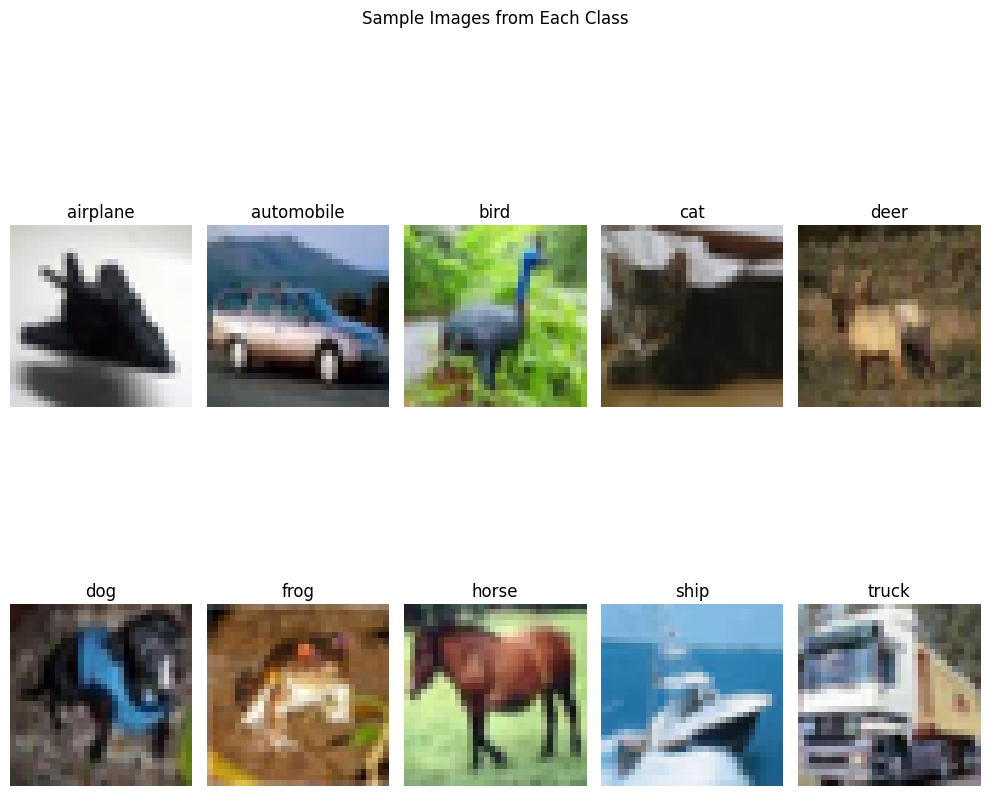

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(CLASSES)):
    # Find the index of the first image in the current class
    for j in range(len(y_train)):
        if y_train[j] == i:
            idx = j
            break

    # Get the first image in the current class
    image = X_train[idx]

    # Plot the image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[i])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout()
plt.show()

# UTILS

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
import joblib
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd


def save_model(model, model_name):
    joblib.dump(model, f'{model_name}.pkl')
    print("Model saved!")


def load_model(model_name):
    model = joblib.load(f'{model_name}.pkl')

    return model


def test(model, images, labels, model_name):
    pred = model.predict(images)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    print(
        f'Model: {model_name} | Test Accuracy: {acc*100:.2f}% | Test F1 score: {f1*100:.2f}% | Precision: {precision*100:.2f}% | Recall: {recall*100:.2f}%'
    )
    return acc, f1, precision, recall


def train(pipeline, params, x, y, n_folds=5):
    k_fold = KFold(n_splits=n_folds)
    model = GridSearchCV(
        pipeline,
        params,
        cv=k_fold,
        scoring='accuracy',
        refit='accuracy',
        verbose=2
    )
    model.fit(x, y)

    display_best_parameters(model)

    return model


def create_comparison(models, names, x_test, y_test):
    results = []
    for model, name in zip(models, names):
        display_best_parameters(model, name)
        acc, f1, precision, recall = test(model, x_test, y_test, name)
        results.append([name, 'Accuracy', acc])
        results.append([name, 'F1 Score', f1])
        results.append([name, 'Precision', precision])
        results.append([name, 'Recall', recall])
    results = pd.DataFrame(results, columns=['Model', 'Metric', 'Score'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x='Model', y='Score', hue='Metric', data=results)
    plt.title('Test Accuracy, F1 Score, Precision, and Recall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results


def display_best_parameters(model, name='Model'):
    best_params = {
        key.replace("onevsoneclassifier__estimator__", "")
        .replace("onevsrestclassifier__estimator__", ""): value
        for key, value in model.best_params_.items()
    }
    best_score = f"{model.best_score_ * 100:.2f}%"
    print(f"> Model: {name}")
    print(f"\t> Best parameters: {best_params}")
    print(f'\t> Best training score: {best_score}\n')


def show_confusion_matrix(model, images, labels):
    pred = model.predict(images)
    cm = confusion_matrix(labels, pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.title('Confusion Matrix')
    plt.show()


def show_first_n_predictions(model, images, labels, n=10):
    pred = model.predict(images)
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(32, 32, 3))
        plt.title(f'True: {CLASSES[labels[i]]}\nPred: {CLASSES[pred[i]]}')
        plt.axis('off')
    plt.show()

# LOGISTIC REGRESSION

## TRAINING

### 1vR

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

if TRAIN:
    log_reg_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
        OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
    )

    param_grid = {
        'onevsrestclassifier__estimator__C': [0.1, 1, 10, 100],
        'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
        'onevsrestclassifier__estimator__solver': ['liblinear', 'saga']
    }

    model = train(log_reg_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "log_reg_model")

### 1v1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

if TRAIN:
    log_reg_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
        OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state=42))
    )

    param_grid = {
        'onevsoneclassifier__estimator__C': [0.1, 1, 10, 100],
        'onevsoneclassifier__estimator__penalty': ['l1', 'l2'],
        'onevsoneclassifier__estimator__solver': ['liblinear', 'saga']
    }

    model = train(log_reg_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "log_reg_ovo_model")

## TESTING

### 1vR

              precision    recall  f1-score   support

    airplane       0.44      0.49      0.47      1000
  automobile       0.46      0.49      0.47      1000
        bird       0.31      0.25      0.28      1000
         cat       0.31      0.26      0.28      1000
        deer       0.38      0.28      0.32      1000
         dog       0.35      0.34      0.35      1000
        frog       0.42      0.53      0.47      1000
       horse       0.44      0.44      0.44      1000
        ship       0.47      0.53      0.50      1000
       truck       0.44      0.47      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



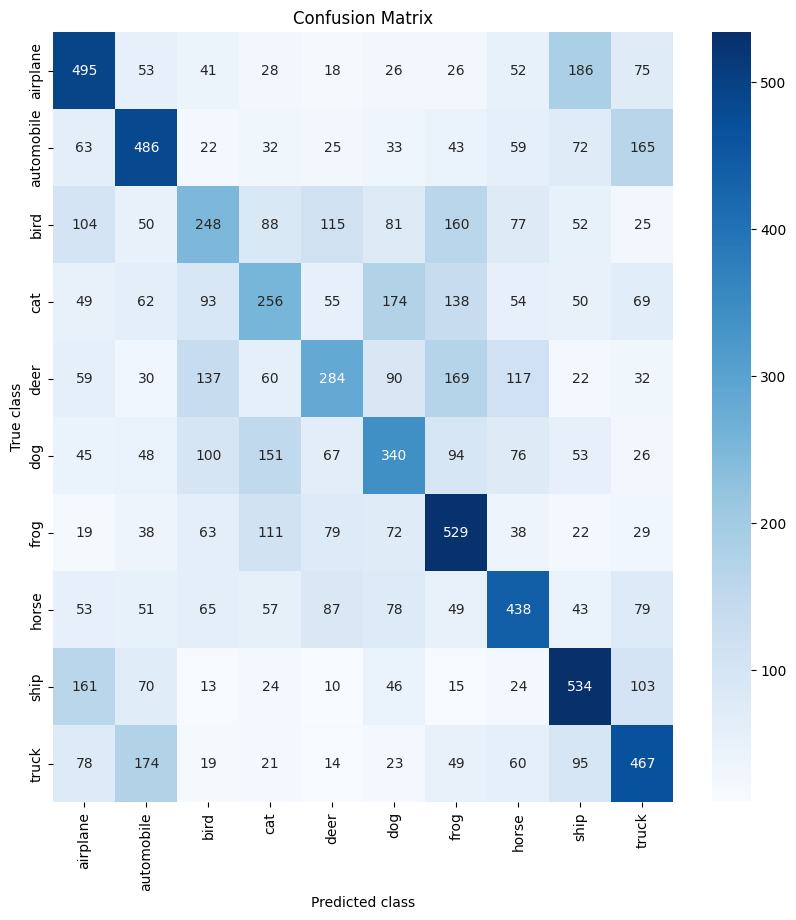

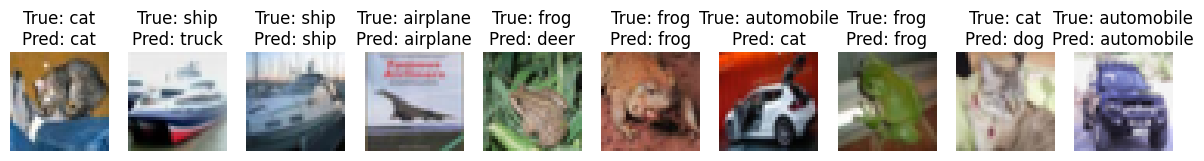

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/log_reg_ovr_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

### 1v1

              precision    recall  f1-score   support

    airplane       0.47      0.49      0.48      1000
  automobile       0.48      0.48      0.48      1000
        bird       0.32      0.28      0.30      1000
         cat       0.32      0.28      0.30      1000
        deer       0.36      0.30      0.33      1000
         dog       0.34      0.35      0.34      1000
        frog       0.43      0.52      0.47      1000
       horse       0.46      0.44      0.45      1000
        ship       0.50      0.54      0.52      1000
       truck       0.46      0.50      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



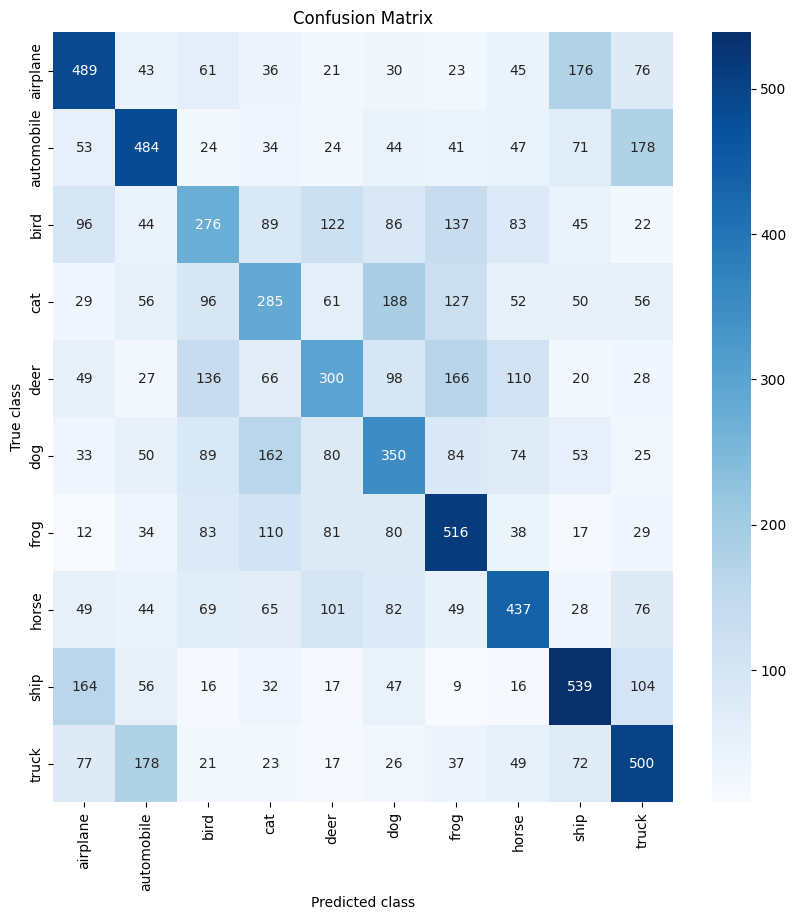

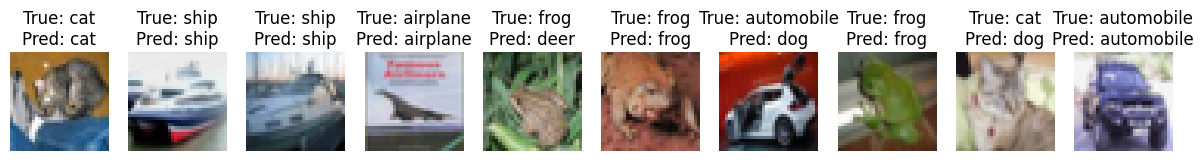

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/log_reg_ovo_model")
y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))
show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

# SVM

## TRAINING

### 1vR

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

if TRAIN:
    svm_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsRestClassifier(SVC(random_state=42, kernel='rbf'))
    )

    param_grid = {
        'onevsrestclassifierestimatorC': [0.1, 1, 10, 100],
        'onevsrestclassifierestimatorgamma': [0.1, 0.01, 'scale', 'auto']
    }

    model = train(svm_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "svm_model")

### 1v1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

if TRAIN:
    svm_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsOneClassifier(SVC(random_state=42, kernel='rbf'))
    )

    param_grid = {
        'onevsoneclassifierestimatorC': [0.1, 1, 10, 100],
        'onevsoneclassifierestimatorgamma': [0.1, 0.01, 'scale', 'auto']
    }

    model = train(svm_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "svm_ovo_model")

## TESTING

### 1vR

              precision    recall  f1-score   support

    airplane       0.65      0.67      0.66      1000
  automobile       0.67      0.67      0.67      1000
        bird       0.48      0.43      0.46      1000
         cat       0.41      0.36      0.38      1000
        deer       0.53      0.50      0.51      1000
         dog       0.51      0.47      0.49      1000
        frog       0.57      0.69      0.62      1000
       horse       0.65      0.66      0.65      1000
        ship       0.67      0.74      0.70      1000
       truck       0.64      0.63      0.63      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



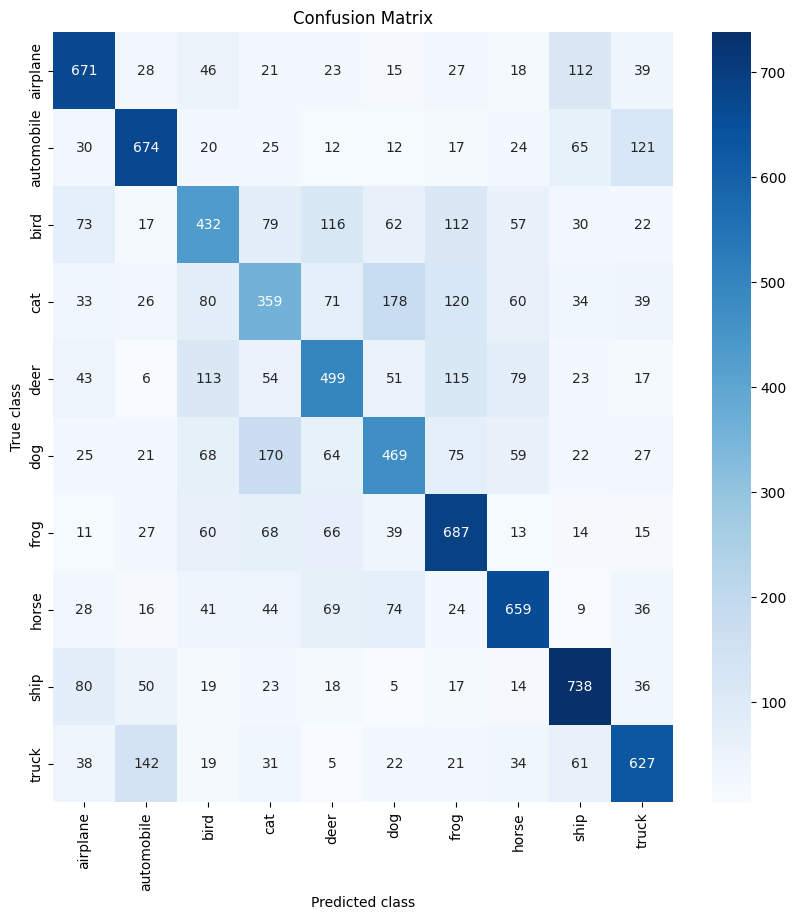

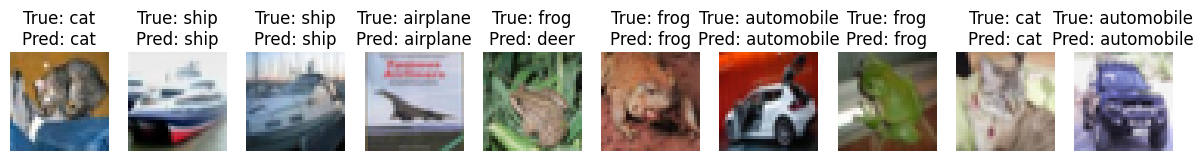

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/svm_ovr_model")
y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))
show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

### 1v1

              precision    recall  f1-score   support

    airplane       0.65      0.65      0.65      1000
  automobile       0.67      0.67      0.67      1000
        bird       0.45      0.45      0.45      1000
         cat       0.39      0.40      0.40      1000
        deer       0.51      0.50      0.50      1000
         dog       0.49      0.47      0.48      1000
        frog       0.61      0.64      0.62      1000
       horse       0.65      0.61      0.63      1000
        ship       0.69      0.70      0.70      1000
       truck       0.60      0.63      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



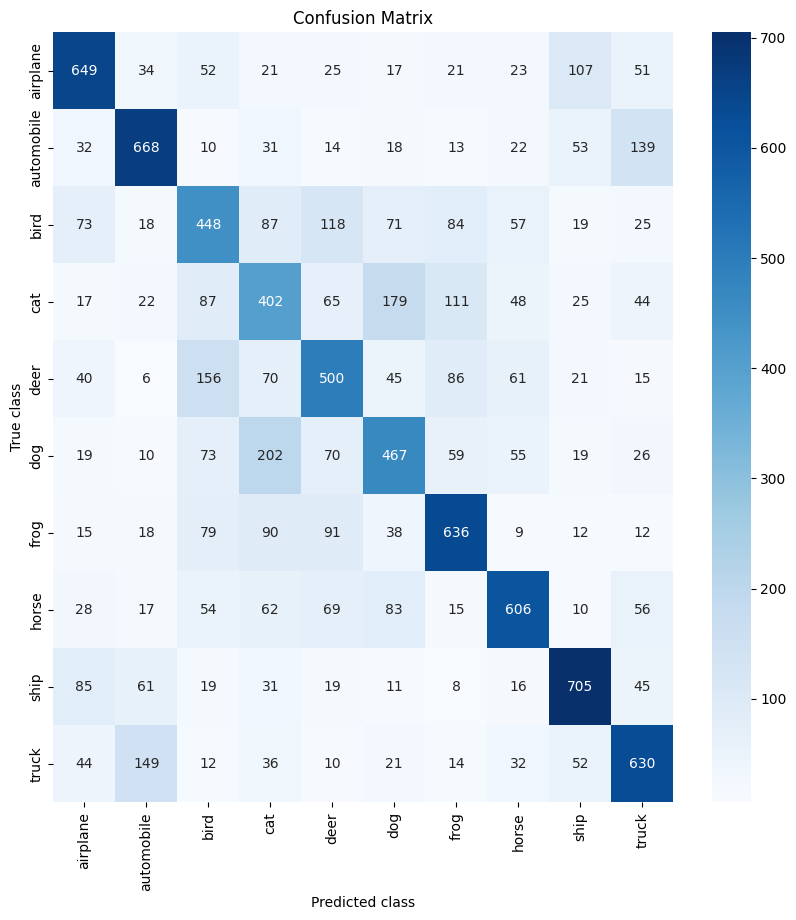

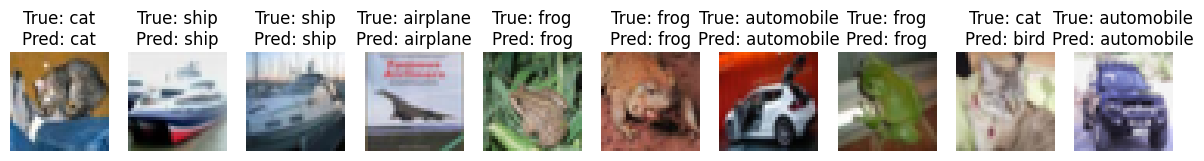

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/svm_ovo_model")
y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))
show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

# KNN


## TRAINING

### 1vR

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

if TRAIN:
    knn_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
        OneVsRestClassifier(KNeighborsClassifier())
    )

    param_grid = {
        'onevsrestclassifier__estimator__n_neighbors': [5, 7, 9, 11],
        'onevsrestclassifier__estimator__weights': ['uniform', 'distance'],
        'onevsrestclassifier__estimator__metric': ['euclidean', 'minkowski']
    }

    model = train(knn_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "knn_model")

### 1V1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import make_pipeline

if TRAIN:
    knn_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
        OneVsOneClassifier(KNeighborsClassifier())
    )

    param_grid = {
        'onevsoneclassifier__estimator__n_neighbors': [5, 7, 9, 11],
        'onevsoneclassifier__estimator__weights': ['uniform', 'distance'],
        'onevsoneclassifier__estimator__metric': ['euclidean', 'minkowski']
    }

    model = train(knn_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "knn_ovo_model")

## TESTING

### 1vR

              precision    recall  f1-score   support

    airplane       0.48      0.52      0.49      1000
  automobile       0.71      0.24      0.36      1000
        bird       0.27      0.41      0.32      1000
         cat       0.32      0.21      0.26      1000
        deer       0.26      0.53      0.35      1000
         dog       0.42      0.27      0.33      1000
        frog       0.34      0.43      0.38      1000
       horse       0.63      0.31      0.42      1000
        ship       0.42      0.68      0.52      1000
       truck       0.69      0.23      0.34      1000

    accuracy                           0.38     10000
   macro avg       0.45      0.38      0.38     10000
weighted avg       0.45      0.38      0.38     10000



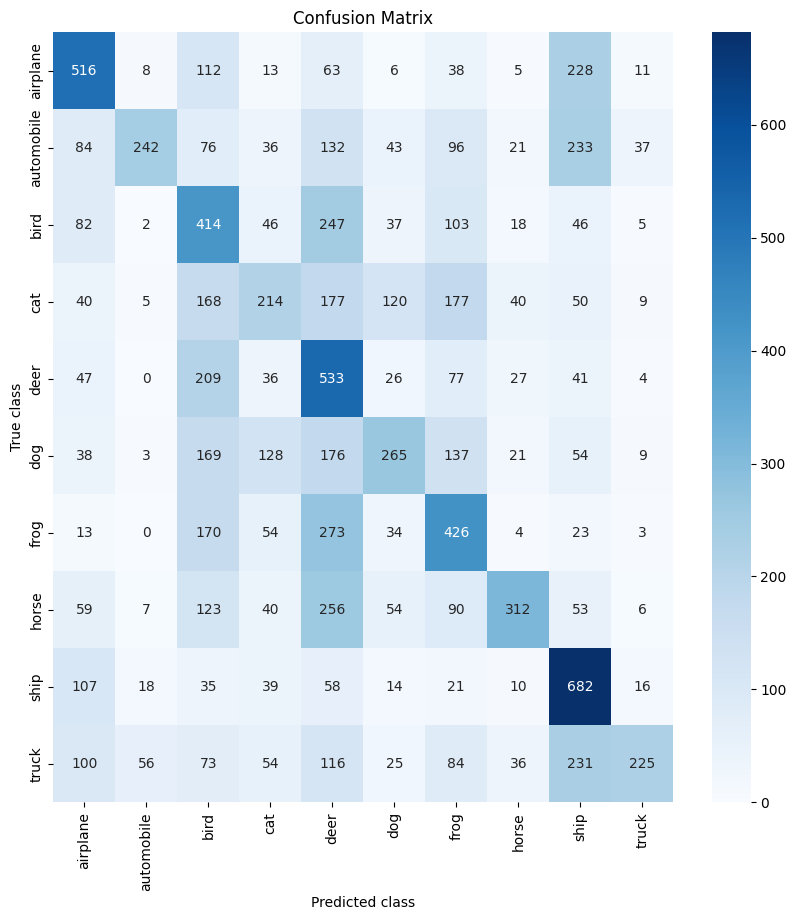

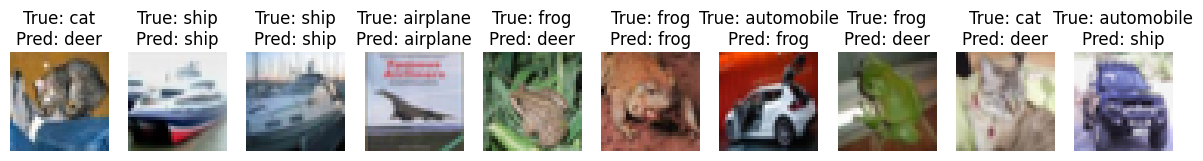

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/knn_ovr_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

### 1v1

              precision    recall  f1-score   support

    airplane       0.47      0.51      0.49      1000
  automobile       0.71      0.23      0.35      1000
        bird       0.26      0.41      0.32      1000
         cat       0.31      0.20      0.24      1000
        deer       0.25      0.52      0.34      1000
         dog       0.42      0.26      0.32      1000
        frog       0.34      0.43      0.38      1000
       horse       0.65      0.30      0.41      1000
        ship       0.41      0.67      0.51      1000
       truck       0.71      0.23      0.35      1000

    accuracy                           0.38     10000
   macro avg       0.45      0.38      0.37     10000
weighted avg       0.45      0.38      0.37     10000



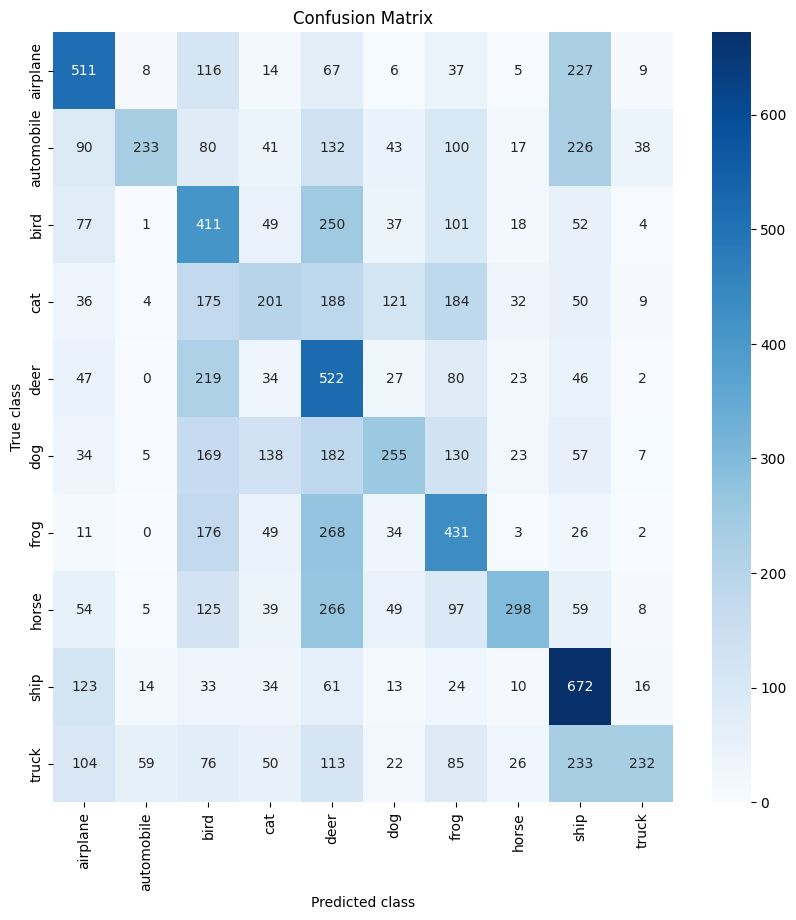

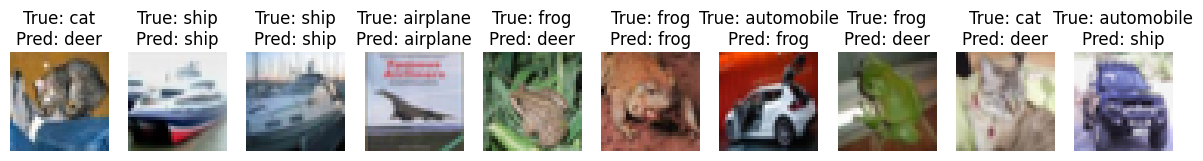

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/knn_ovo_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

# GNB


## TRAINING


### 1vR

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier

if TRAIN:
    nb_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsRestClassifier(GaussianNB())
    )

    param_grid = {
        'onevsrestclassifier__estimator__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
    }

    model = train(nb_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "gnb_ovr_model")

### 1v1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import make_pipeline

if TRAIN:
    nb_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsOneClassifier(GaussianNB())
    )

    param_grid = {
        'onevsoneclassifier__estimator__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
    }

    model = train(nb_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "gnb_ovo_model")

## TESTING

### 1vR

              precision    recall  f1-score   support

    airplane       0.36      0.15      0.21      1000
  automobile       0.37      0.45      0.41      1000
        bird       0.24      0.12      0.16      1000
         cat       0.26      0.15      0.19      1000
        deer       0.21      0.63      0.32      1000
         dog       0.36      0.17      0.23      1000
        frog       0.47      0.26      0.33      1000
       horse       0.42      0.28      0.33      1000
        ship       0.36      0.33      0.34      1000
       truck       0.28      0.48      0.36      1000

    accuracy                           0.30     10000
   macro avg       0.33      0.30      0.29     10000
weighted avg       0.33      0.30      0.29     10000



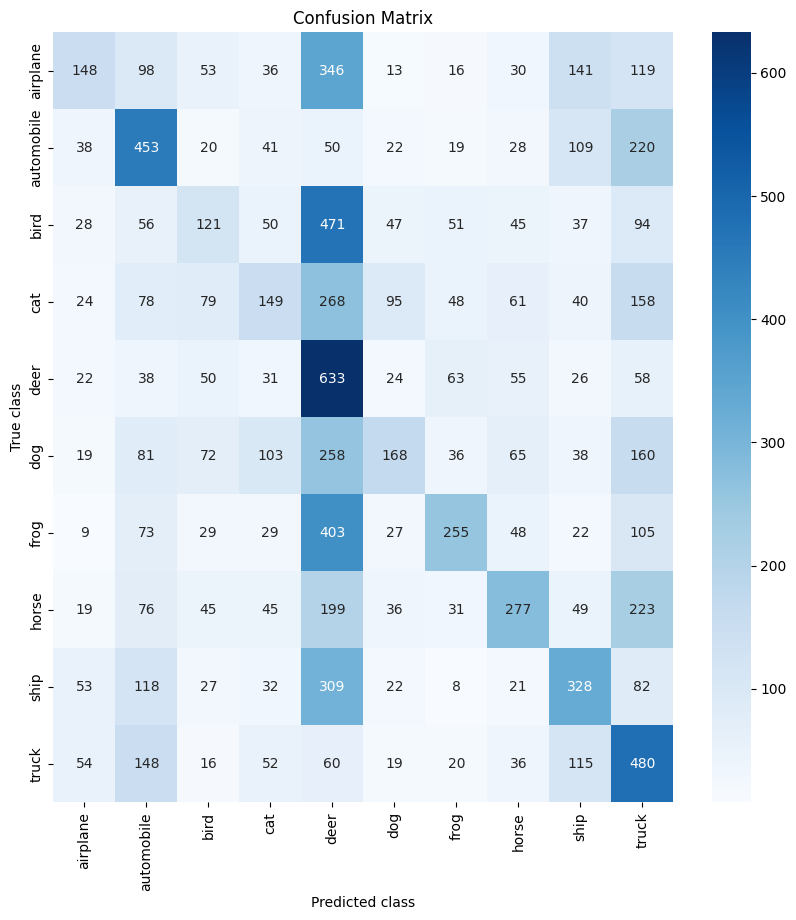

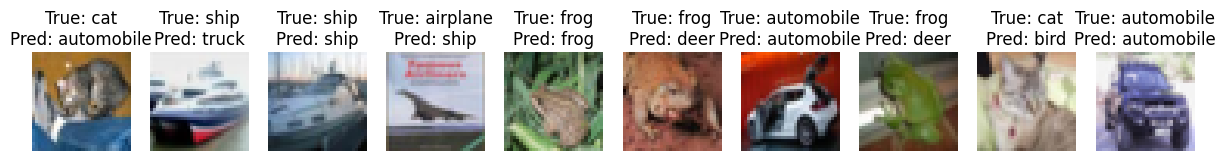

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/gnb_ovr_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

### 1V1

              precision    recall  f1-score   support

    airplane       0.33      0.14      0.20      1000
  automobile       0.38      0.46      0.42      1000
        bird       0.23      0.12      0.16      1000
         cat       0.25      0.16      0.20      1000
        deer       0.21      0.62      0.32      1000
         dog       0.34      0.17      0.23      1000
        frog       0.47      0.27      0.34      1000
       horse       0.40      0.30      0.34      1000
        ship       0.36      0.33      0.35      1000
       truck       0.29      0.45      0.35      1000

    accuracy                           0.30     10000
   macro avg       0.33      0.30      0.29     10000
weighted avg       0.33      0.30      0.29     10000



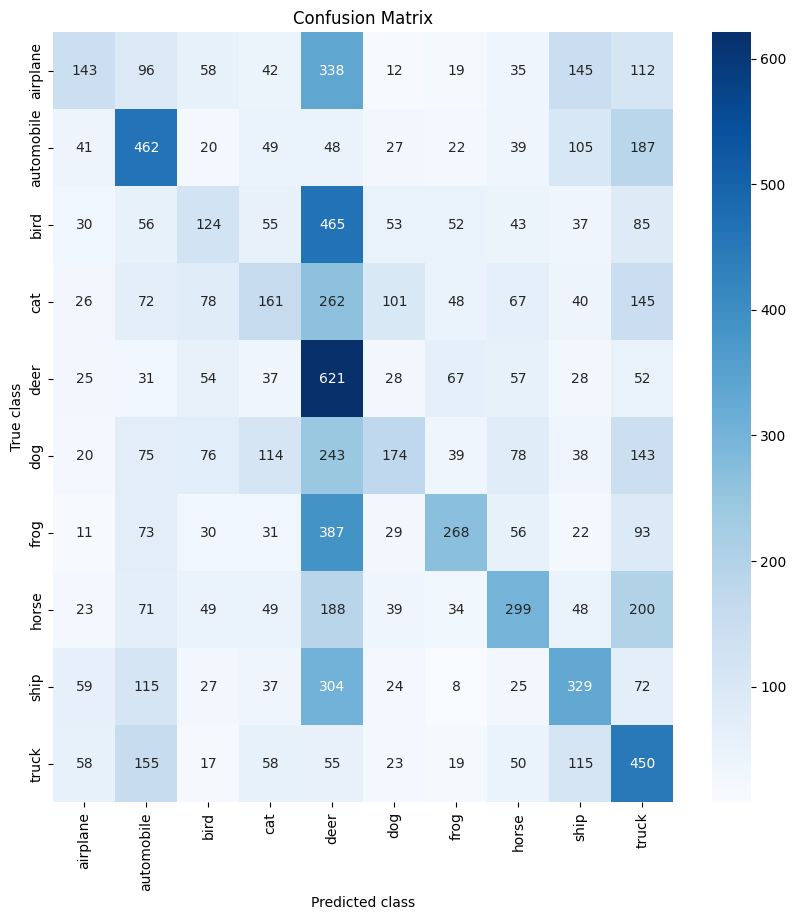

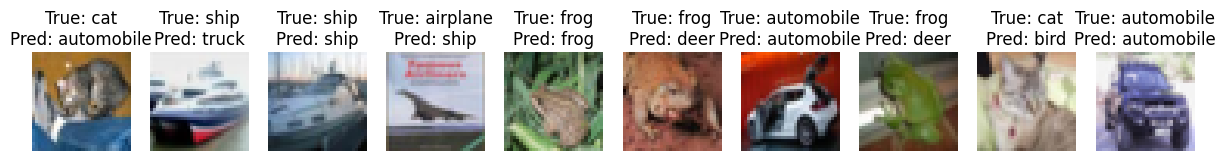

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/gnb_ovo_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

# RANDOM FOREST


## TRAINING

### 1vR

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

if TRAIN:
    rfc_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsRestClassifier(RandomForestClassifier(random_state=42))
    )

    param_grid = {
        'onevsrestclassifier__estimator__n_estimators': [10, 50, 100],
        'onevsrestclassifier__estimator__max_features': ['sqrt', 'log2'],
        'onevsrestclassifier__estimator__min_samples_leaf': [1, 2, 4]
    }

    model = train(rfc_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "rfc_ovr_model")

### 1V1

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

if TRAIN:
    rfc_pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95, svd_solver='full', random_state=42),
        OneVsOneClassifier(RandomForestClassifier(random_state=42))
    )

    param_grid = {
        'onevsoneclassifier__estimator__n_estimators': [10, 50, 100],
        'onevsoneclassifier__estimator__max_features': ['sqrt', 'log2'],
        'onevsoneclassifier__estimator__min_samples_leaf': [1, 2, 4]
    }

    model = train(rfc_pipeline, param_grid, X_train_flat, y_train)
    save_model(model, "rfc_ovo_model")

## TESTING

### 1vR

              precision    recall  f1-score   support

    airplane       0.55      0.53      0.54      1000
  automobile       0.51      0.59      0.55      1000
        bird       0.39      0.30      0.34      1000
         cat       0.33      0.27      0.30      1000
        deer       0.43      0.43      0.43      1000
         dog       0.40      0.36      0.38      1000
        frog       0.48      0.59      0.53      1000
       horse       0.52      0.44      0.48      1000
        ship       0.52      0.63      0.57      1000
       truck       0.47      0.51      0.49      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



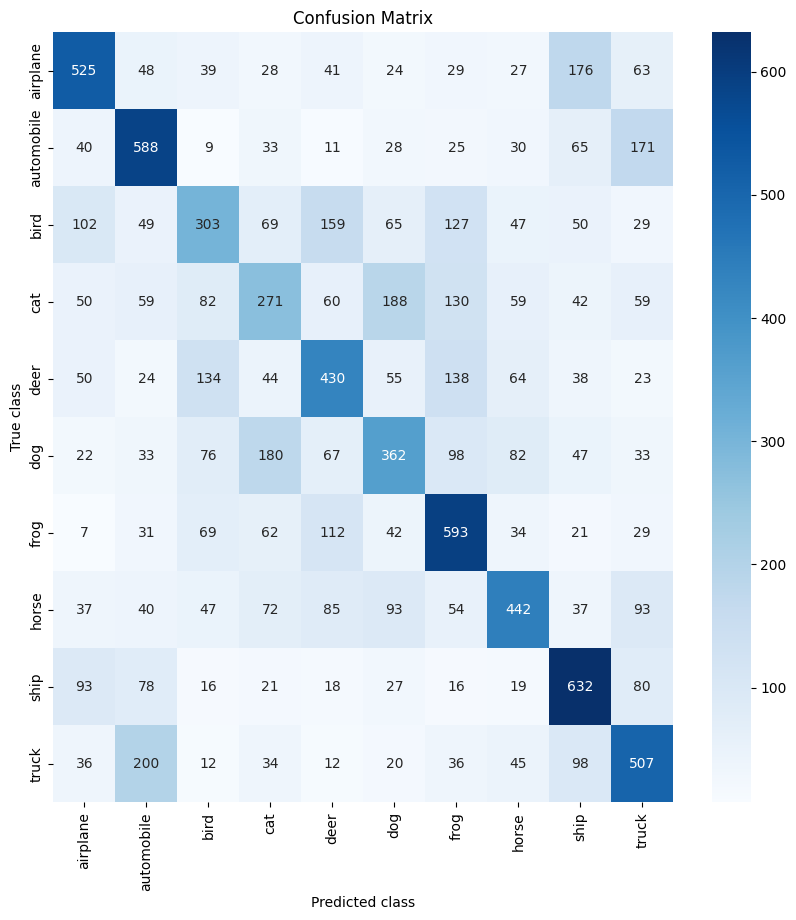

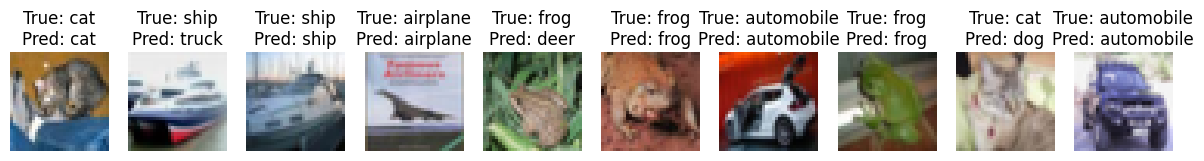

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/rfc_ovr_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

### 1v1

              precision    recall  f1-score   support

    airplane       0.60      0.53      0.56      1000
  automobile       0.51      0.59      0.55      1000
        bird       0.41      0.24      0.30      1000
         cat       0.31      0.29      0.30      1000
        deer       0.48      0.37      0.42      1000
         dog       0.38      0.40      0.39      1000
        frog       0.52      0.54      0.53      1000
       horse       0.45      0.48      0.47      1000
        ship       0.59      0.58      0.59      1000
       truck       0.41      0.62      0.49      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     10000



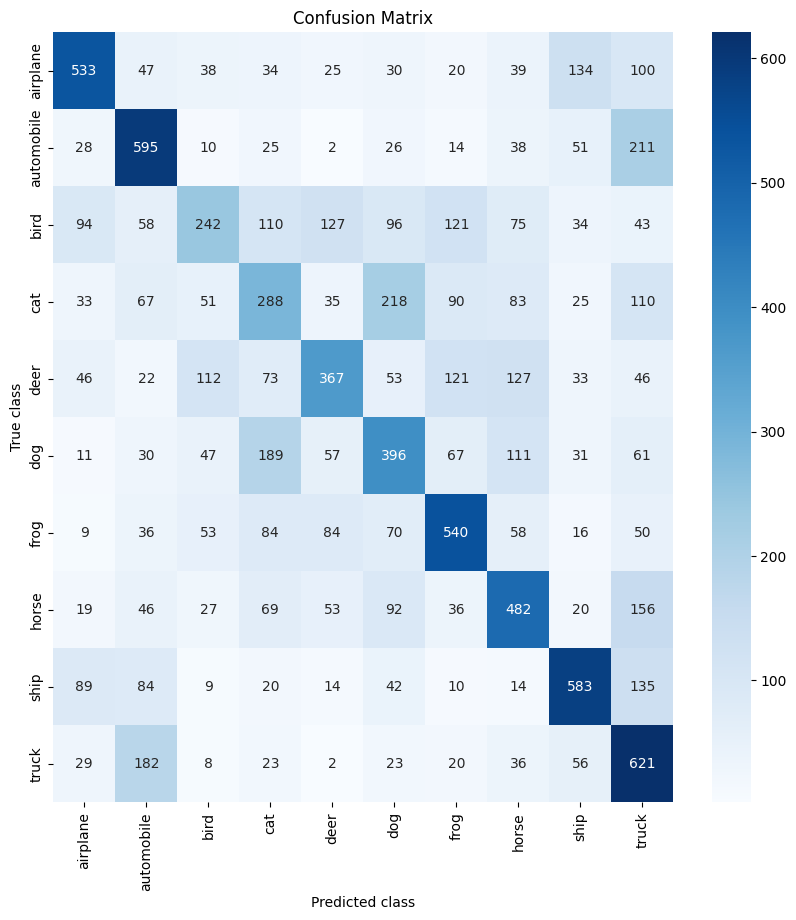

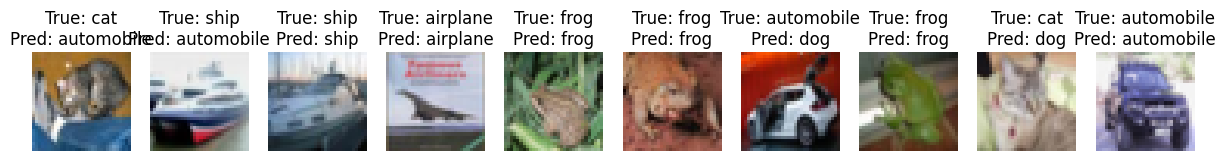

In [ ]:
from sklearn.metrics import classification_report

model = load_model("./models/rfc_ovo_model")

y_pred = model.predict(X_test_flat)

print(classification_report(y_test, y_pred, target_names=CLASSES))

show_confusion_matrix(model, X_test_flat, y_test)
show_first_n_predictions(model, X_test_flat, y_test)

# COMPARISON

Model: Logistic Regression (OvR) | Test Accuracy: 40.77% | Test F1 score: 40.20% | Precision: 40.11% | Recall: 40.77%
> Model: Logistic Regression (OvR)
	> Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
	> Best score: 40.85%

Model: Logistic Regression (OvO) | Test Accuracy: 41.76% | Test F1 score: 41.43% | Precision: 41.32% | Recall: 41.76%
> Model: Logistic Regression (OvO)
	> Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
	> Best score: 41.64%

Model: Gaussian Naive Bayes (OvR) | Test Accuracy: 30.12% | Test F1 score: 28.75% | Precision: 33.21% | Recall: 30.12%
> Model: Gaussian Naive Bayes (OvR)
	> Best parameters: {'var_smoothing': 1e-11}
	> Best score: 30.16%

Model: Gaussian Naive Bayes (OvO) | Test Accuracy: 30.31% | Test F1 score: 29.07% | Precision: 32.72% | Recall: 30.31%
> Model: Gaussian Naive Bayes (OvO)
	> Best parameters: {'var_smoothing': 1e-11}
	> Best score: 30.52%

Model: K-Nearest Neighbors (OvR) | Test Accuracy: 38.29% | Test F

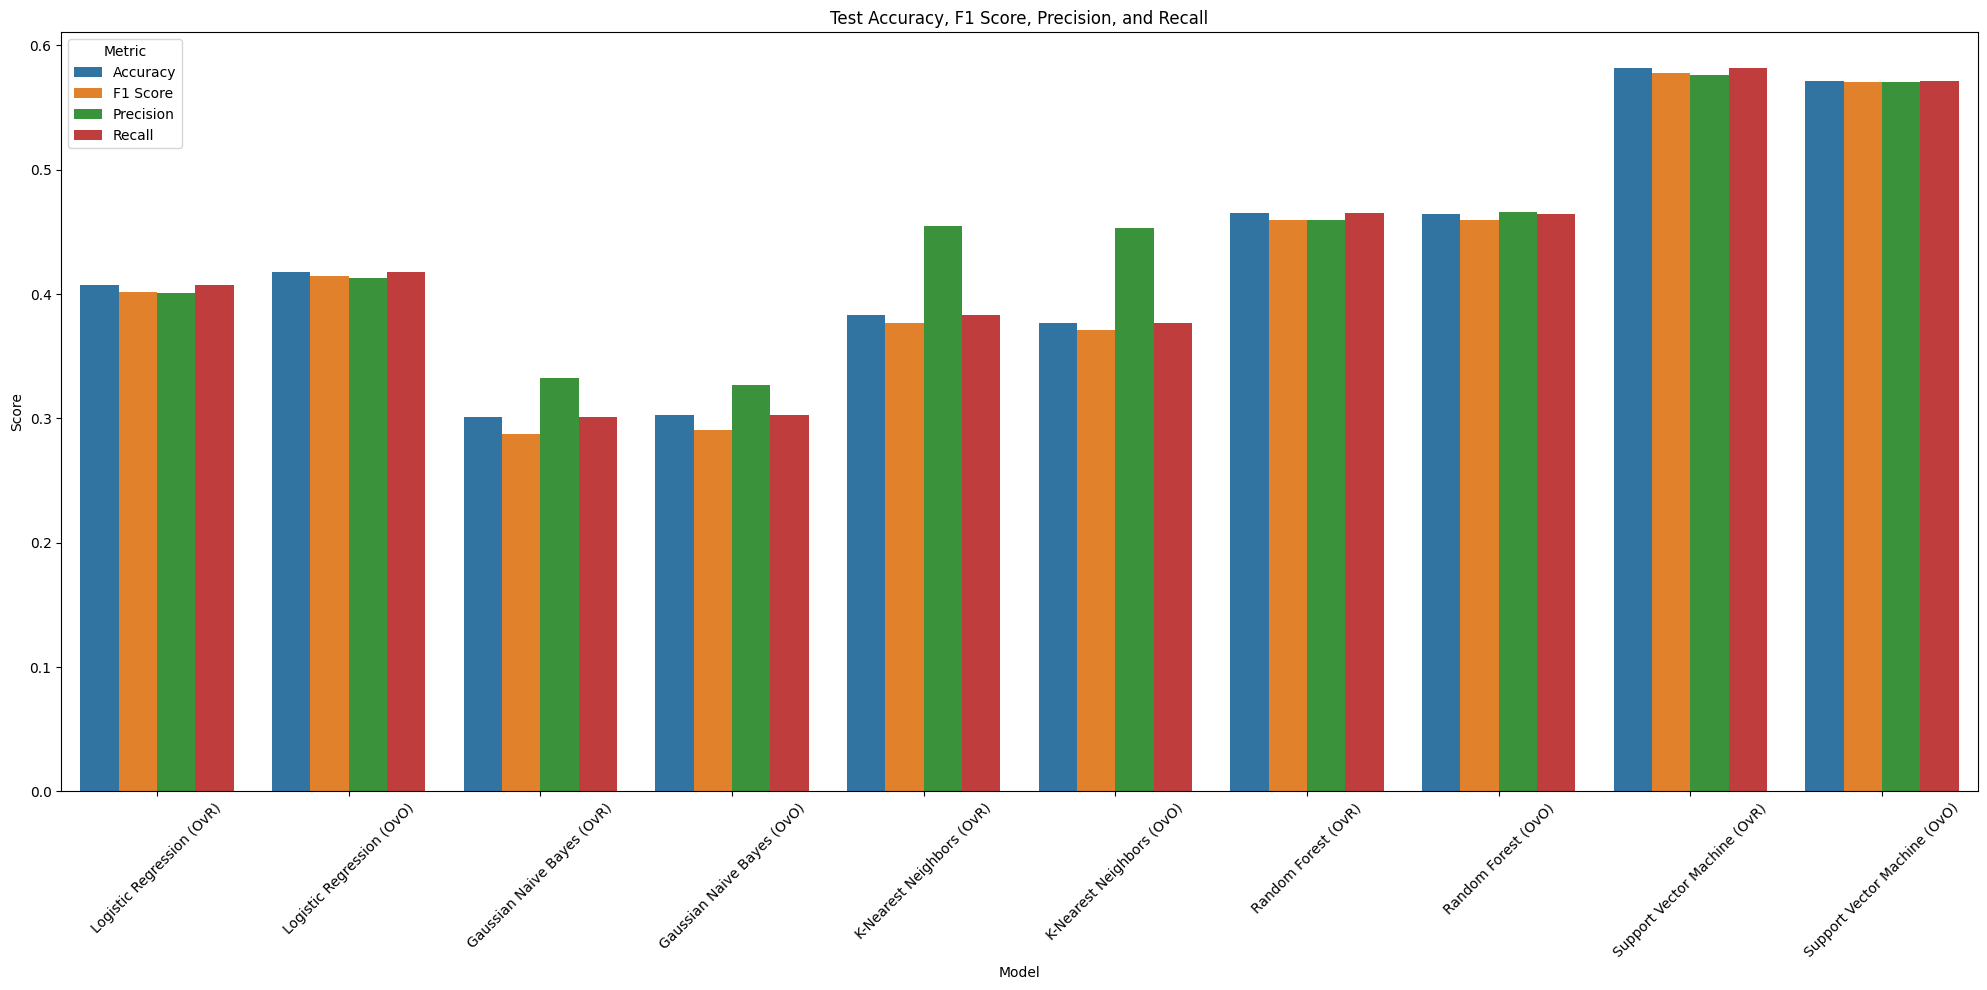

In [ ]:
path = "./models/"

log_reg_ovr_model = load_model(path + "log_reg_ovr_model")
log_reg_ovo_model = load_model(path + "log_reg_ovo_model")
gnb_ovr_model = load_model(path + "gnb_ovr_model")
gnb_ovo_model = load_model(path + "gnb_ovo_model")
knn_ovr_model = load_model(path + "knn_ovr_model")
knn_ovo_model = load_model(path + "knn_ovo_model")
rfc_ovr_model = load_model(path + "rfc_ovr_model")
rfc_ovo_model = load_model(path + "rfc_ovo_model")
svm_ovr_model = load_model(path + "svm_ovr_model")
svm_ovo_model = load_model(path + "svm_ovo_model")

comparison = create_comparison(
    [
        log_reg_ovr_model,
        log_reg_ovo_model,
        gnb_ovr_model,
        gnb_ovo_model,
        knn_ovr_model,
        knn_ovo_model,
        rfc_ovr_model,
        rfc_ovo_model,
        svm_ovr_model,
        svm_ovo_model
    ],
    [
        "Logistic Regression (OvR)",
        "Logistic Regression (OvO)",
        "Gaussian Naive Bayes (OvR)",
        "Gaussian Naive Bayes (OvO)",
        "K-Nearest Neighbors (OvR)",
        "K-Nearest Neighbors (OvO)",
        "Random Forest (OvR)",
        "Random Forest (OvO)",
        "Support Vector Machine (OvR)",
        "Support Vector Machine (OvO)"
    ],
    X_test_flat,
    y_test
)

df_ovr = comparison[comparison["Model"].str.contains("OvR")].pivot(
    index="Model", columns="Metric", values="Score")
df_ovo = comparison[comparison["Model"].str.contains("OvO")].pivot(
    index="Model", columns="Metric", values="Score")

In [13]:
df_ovr

Metric,Accuracy,F1 Score,Precision,Recall
Model,,,,
Gaussian Naive Bayes (OvR),0.3012,0.287482,0.332119,0.3012
K-Nearest Neighbors (OvR),0.3829,0.376897,0.454400,0.3829
Logistic Regression (OvR),0.4077,0.402040,0.401126,0.4077
Random Forest (OvR),0.4653,0.459637,0.459458,0.4653
Support Vector Machine (OvR),0.5815,0.577845,0.576636,0.5815


In [12]:
df_ovo

Metric,Accuracy,F1 Score,Precision,Recall
Model,,,,
Gaussian Naive Bayes (OvO),0.3031,0.290653,0.327217,0.3031
K-Nearest Neighbors (OvO),0.3766,0.370923,0.453483,0.3766
Logistic Regression (OvO),0.4176,0.414282,0.413185,0.4176
Random Forest (OvO),0.4647,0.459472,0.465720,0.4647
Support Vector Machine (OvO),0.5711,0.570847,0.570997,0.5711
